In [39]:
from path import Path
from fastai.vision import *
import numpy as np
import pandas as pd
from PIL import Image

In [1]:
# ! kaggle competitions download -c digit-recognizer

 89%|█████████████████████████████████▋    | 65.0M/73.2M [00:00<00:00, 85.5MB/s]
100%|███████████████████████████████████████| 73.2M/73.2M [00:00<00:00, 151MB/s]
 84%|███████████████████████████████▉      | 41.0M/48.8M [00:00<00:00, 45.9MB/s]
100%|███████████████████████████████████████| 48.8M/48.8M [00:00<00:00, 102MB/s]
  0%|                                                | 0.00/235k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 235k/235k [00:00<00:00, 157MB/s]


In [10]:
path = Path('/home/jupyter/kaggle/digit-recognizer/data')

In [11]:
path.ls()

[PosixPath('/home/jupyter/kaggle/digit-recognizer/data/test.csv'),
 PosixPath('/home/jupyter/kaggle/digit-recognizer/data/train.csv'),
 PosixPath('/home/jupyter/kaggle/digit-recognizer/data/sample_submission.csv')]

In [157]:
dataset = 'test'
df = pd.read_csv(path/'{0}.csv'.format(dataset))
df_labels = pd.DataFrame(columns=['name', 'label'])
cols = [col for col in df.columns if col != 'label']
label_path = path/'{0}/labels.csv'.format(dataset)

In [160]:
counter = 10000
for idx in df.index:
    if dataset == 'train':
        label = df.iloc[idx]['label']
    else:
        label = '0'
    img_as_np = np.asarray(df.iloc[idx][cols]).reshape(28, 28).astype('uint8')
    img_as_img = Image.fromarray(img_as_np)
    img_as_img = img_as_img.convert('L')
    filename = '{0}/{1}_{2}.jpg'.format(dataset, label, idx)
    img_as_img.save(path/filename)
    df_labels = df_labels.append({'name':filename,'label':label}, ignore_index=True)
    if idx % counter == 0:
        print(idx)
df_labels.to_csv(label_path, index=False)

0
10000
20000


In [1]:
tfms = get_transforms(do_flip=False)
np.random.seed(42)
data = (ImageList.from_csv(path/'train', csv_name='labels.csv')
       .split_by_rand_pct(.1)
       .label_from_df()
       .transform(tfms, size=128)
       .databunch())

NameError: name 'get_transforms' is not defined

In [117]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [119]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.227573,0.104956,0.964286,01:02
1,0.103702,0.048278,0.983810,00:59
2,0.074377,0.033001,0.989048,01:00
3,0.055841,0.031149,0.988810,01:00


In [120]:
learn.save('stage-1')

In [126]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (37800 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,4,0,7
Path: /home/jupyter/kaggle/digit-recognizer/data/train;

Valid: LabelList (4200 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
8,1,9,9,8
Path: /home/jupyter/kaggle/digit-recognizer/data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momen

In [127]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


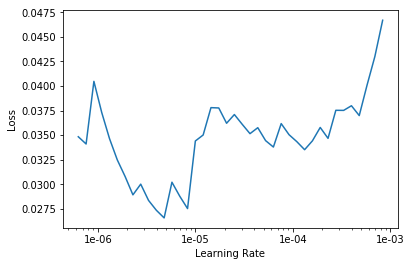

In [130]:
learn.lr_find(); learn.recorder.plot()

In [131]:
learn.fit_one_cycle(2, slice(1e-5 / 2, 1e-4 / 2))

epoch,train_loss,valid_loss,accuracy,time
0,0.029053,0.019797,0.993571,01:26
1,0.019704,0.016109,0.993333,01:28


In [132]:
learn.save('stage-2')

In [178]:
df_pred = pd.DataFrame(columns=['ImageId', 'Label'])

In [179]:
for test_path in (path/'test').ls():
    if '.csv' in str(test_path):
        continue
    label = int(learn.predict(open_image(test_path))[0].__str__())
    idx = int(str(test_path).split('/')[-1].split('.')[0].split('_')[1])
    df_pred = df_pred.append({'ImageId':idx, 'Label':label}, ignore_index=True)
    if len(df_pred) % counter == 0:
        print(len(df_pred))

10000
20000


In [180]:
len(df_pred)

28000

In [186]:
df_pred.sort_values('ImageId').to_csv(path/'submission.csv', index=False)

In [191]:
df_pred['ImageId'] += 1

In [194]:
df_pred.sort_values('ImageId').to_csv(path/'submissions.csv', index=False)

In [196]:
df_pred.sort_values('ImageId')

,ImageId,Label
7709,1,2
25090,2,0
16782,3,9
14971,4,0
4102,5,3
5857,6,7
1304,7,0
13178,8,3
9920,9,0
1110,10,3
